In [1]:
import json
import os
import sys
from pathlib import Path

import dabest
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd
import yaml

from mne.time_frequency import AverageTFR, EpochsTFR, tfr_morlet, tfr_multitaper
from mne_bids import BIDSPath
from mne_bids.read import read_raw_bids
from mne_bids.tsv_handler import _from_tsv
from ptitprince import PtitPrince as pt
from rerf.rerfClassifier import rerfClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc, 
    accuracy_score, 
    cohen_kappa_score, 
    make_scorer, 
    plot_confusion_matrix, 
    roc_auc_score, 
    roc_curve
)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from sklearn.utils import check_random_state
from tqdm import tqdm

from cv import fit_classifiers_cv, initialize_classifiers
from functions.move_experiment_functions import (
    get_event_data, 
    get_preprocessed_labels,
)
from functions.time_window_selection_functions import (
    bootstrap_independence_test,
    bootstrap_independence_test_OLS,
    get_event_durations, 
    plot_event_onsets,
    plot_event_durations,
    plot_durations_by_label_raincloud,
    plot_durations_by_label_kde,
    plot_durations_cv_split,
)

if os.path.abspath("../io") not in sys.path:
    sys.path.append(os.path.abspath("../io"))

from read import read_dataset, read_trial, get_trial_info, _get_anatomical_bad_chs
from utils import NumpyEncoder
from experiments import cv_fit
from plotting import (
    plot_signals,
    plot_spectrogram,
    plot_epoch_time_series,
    plot_roc_multiclass_cv,
    plot_feature_importances,
    plot_cv_indices, 
    plot_classifier_performance,
    plot_roc_aucs,
    plot_accuracies,
)

plt.rcParams.update({
    "font.family": "sans-serif", 
    "font.size": 14
})

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Set paths and experiment defaults

In [2]:
with open(Path(os.path.abspath('')) / "config.yml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

with open(Path(os.path.abspath('')) / "metadata.yml") as f:
    metadata = yaml.load(f, Loader=yaml.FullLoader)

bids_root = Path(config["bids_root"])
results_path = Path(config["results_path"])

print(f"bids_root: {bids_root}")
print(f"results_path: {results_path}")

bids_root: /Volumes/Mac/research/data/efri
results_path: /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/derivatives/workstation_output


In [9]:
rng = 1
n_splits = 5
cv = StratifiedKFold(n_splits)

## Time Domain

In [11]:
subjects = metadata["subjects"]

subject_clf_scores = {}
for subject in subjects:
    path_identifiers = dict(subject=subject, session="efri", task="move", 
                            acquisition="seeg", run="01", suffix="ieeg", 
                            extension=".vhdr", root=bids_root)
    bids_path = BIDSPath(**path_identifiers)

    go_cue_durations = get_event_durations(
        bids_path, event_key="Left Target", periods=-1
    )
    left_target_durations = get_event_durations(
        bids_path, event_key="Left Target", periods=1
    )

    tmin = -max(go_cue_durations)
    tmax = max(left_target_durations)

    epochs, labels = get_event_data(bids_path, tmin=tmin - 0.2, tmax=tmax + 0.2)

    data = epochs.get_data()
    ntrials, nchs, nsteps = data.shape
    print(f"{subject.upper()}: data.shape = ({data.shape})")

    t = epochs.times
    mask = (t >= -np.asarray(go_cue_durations)[:, None, None]) & (
        t <= np.asarray(left_target_durations)[:, None, None]
    )
    masked_data = data * mask

    image_height = nchs
    image_width = nsteps

    clfs = initialize_classifiers(image_height, image_width, n_jobs=-1, random_state=rng)
    clf_scores = {}
    for clf in clfs:
        if isinstance(clf, rerfClassifier):
            clf_name = clf.get_params()["projection_matrix"]
        elif isinstance(clf, DummyClassifier):
            clf_name = clf.strategy
        else:
            clf_name = clf.__class__.__name__
        
        filename = results_path / subject / f"trial_specific_window/time_domain/{subject}_{clf_name}_results.json"
        with open(filename) as f:
            clf_scores[clf_name] = json.load(f)
    subject_clf_scores[subject] = clf_scores

Extracting parameters from /Volumes/Mac/research/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Volumes/Mac/research/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Volumes/Mac/research/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Reading 0 ... 9875999  =      0.000 ...  4937.999 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 sec)

Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Leave Targ

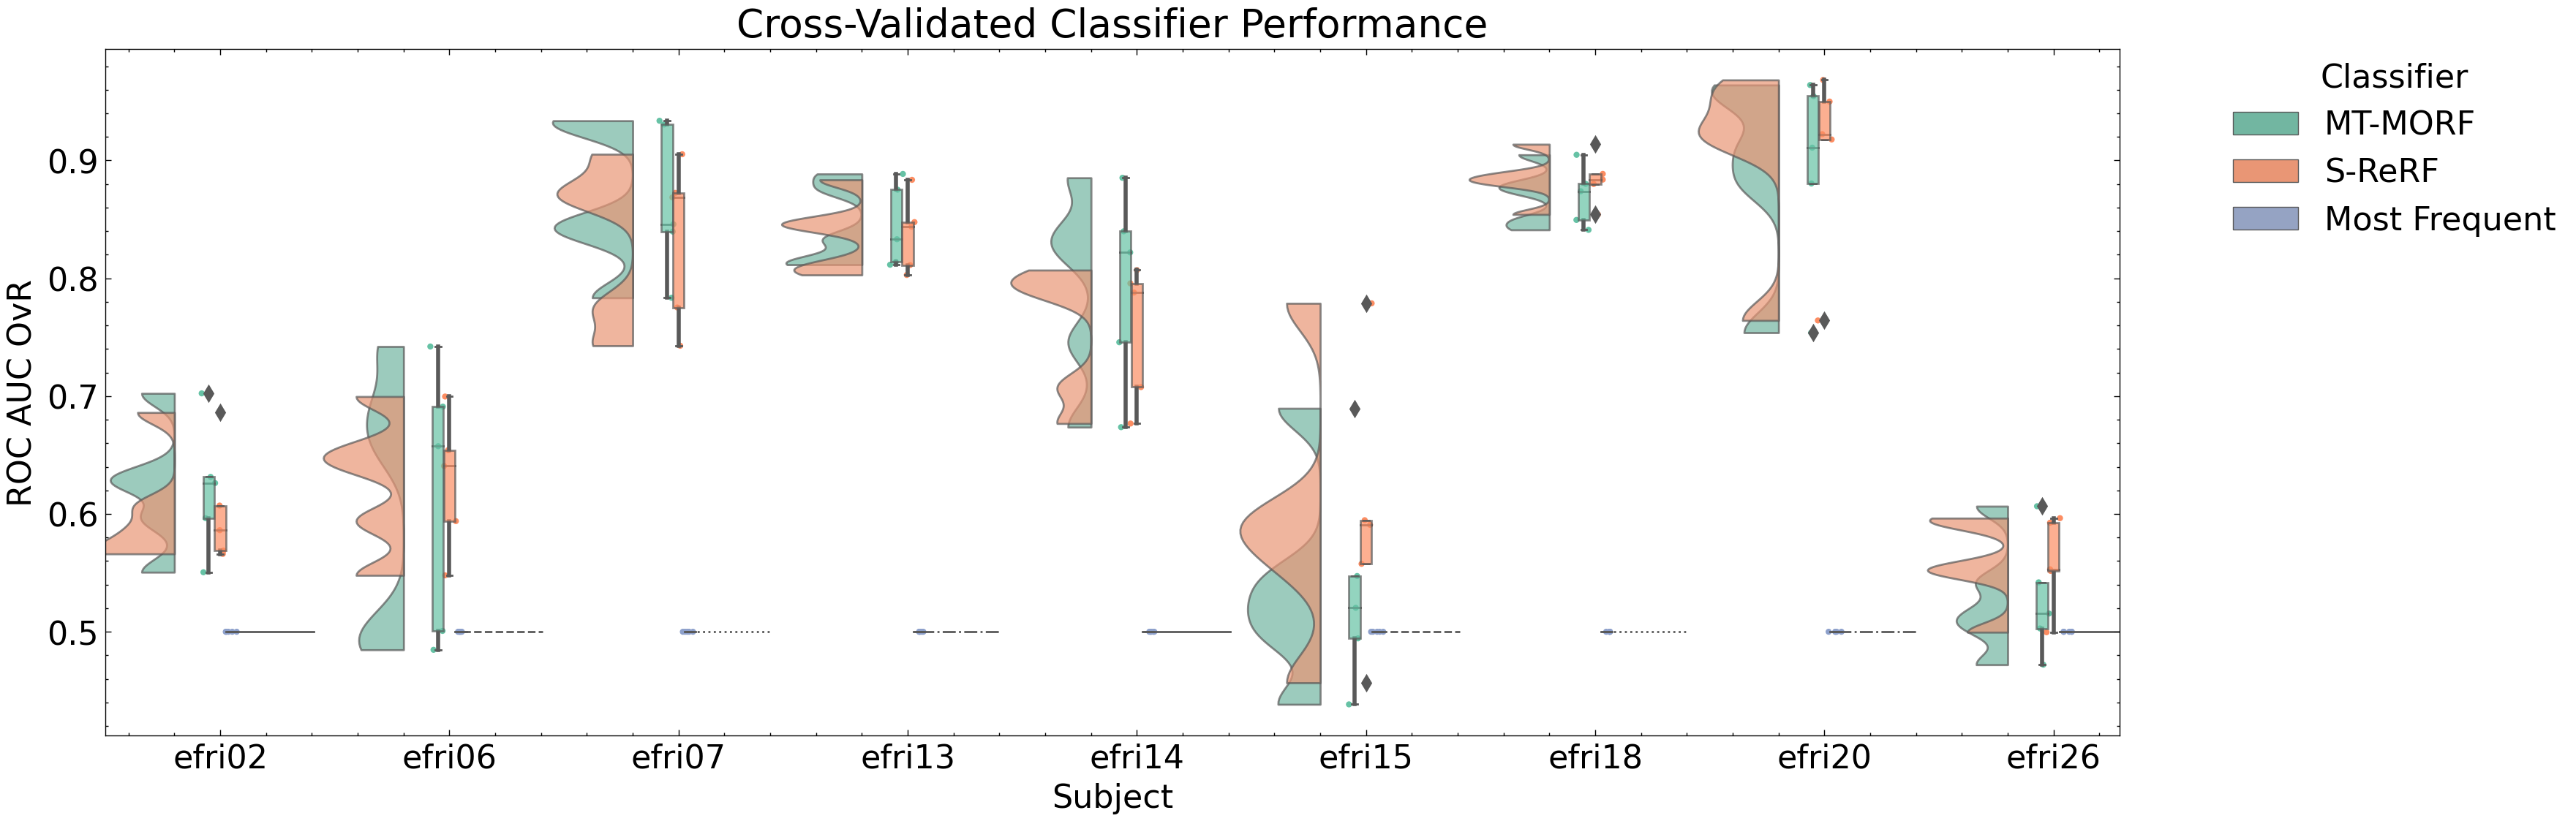

In [22]:
df = pd.DataFrame(columns=["Classifier", "ROC AUC OvR", "Subject"])

for subject, clf_scores in subject_clf_scores.items():
    mtmorf_scores = clf_scores["MT-MORF"]
    srerf_scores = clf_scores["S-RerF"]
    dummy_scores = clf_scores["most_frequent"]

    rocs = {
        "MT-MORF": mtmorf_scores["test_roc_auc_ovr"],
        "S-ReRF": srerf_scores["test_roc_auc_ovr"],
        "Most Frequent": dummy_scores["test_roc_auc_ovr"]
    }
    roc_df = pd.DataFrame(rocs)
    roc_df = pd.melt(roc_df, value_vars=list(rocs.keys()), var_name="Classifier", value_name="ROC AUC OvR")
    roc_df["Subject"] = subject

    df = df.append(roc_df)

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 6), dpi=200)
pt.RainCloud(x="Subject", y="ROC AUC OvR", hue="Classifier", data=df, dodge=True, alpha=0.7, ax=ax)
ax.set_title("Cross-Validated Classifier Performance")
fig.tight_layout();

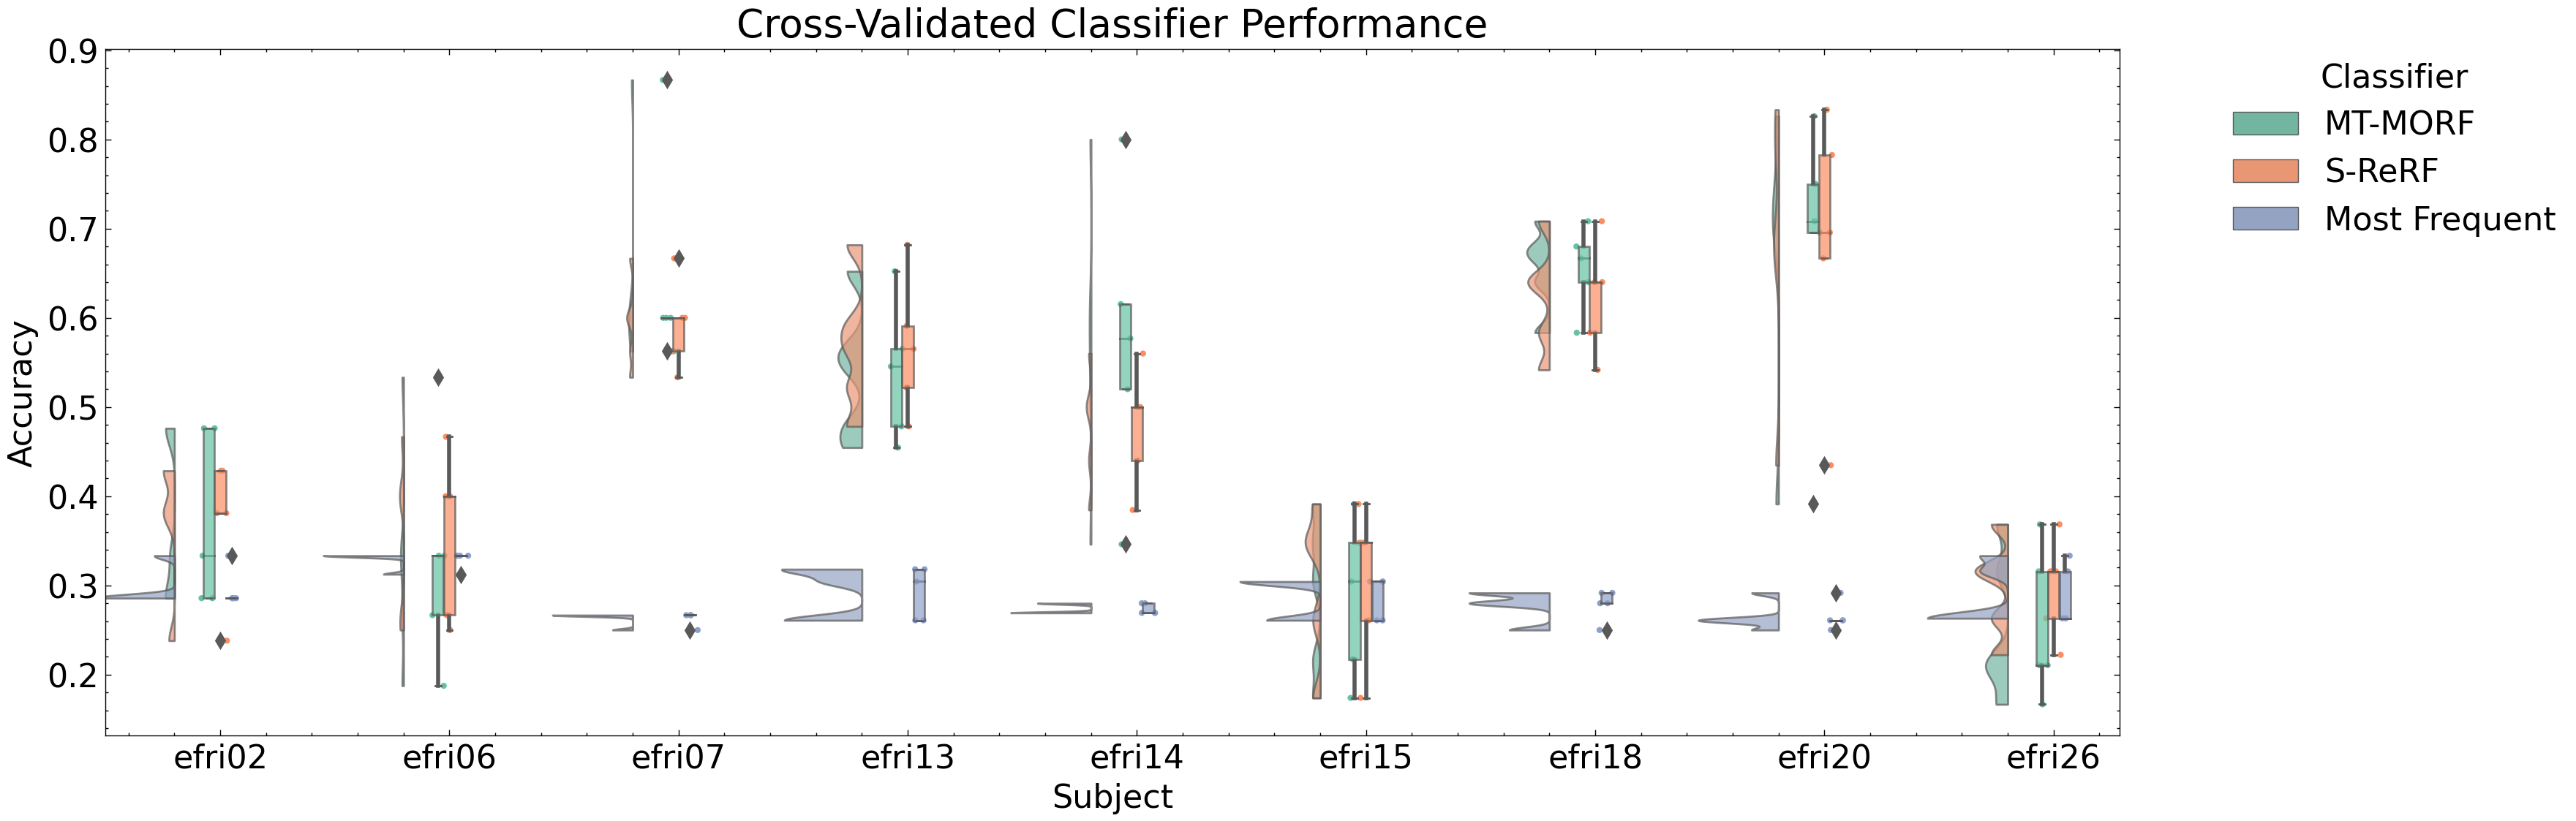

In [23]:
df = pd.DataFrame(columns=["Classifier", "Accuracy", "Subject"])

for subject, clf_scores in subject_clf_scores.items():
    mtmorf_scores = clf_scores["MT-MORF"]
    srerf_scores = clf_scores["S-RerF"]
    dummy_scores = clf_scores["most_frequent"]

    rocs = {
        "MT-MORF": mtmorf_scores["test_accuracy"],
        "S-ReRF": srerf_scores["test_accuracy"],
        "Most Frequent": dummy_scores["test_accuracy"]
    }
    roc_df = pd.DataFrame(rocs)
    roc_df = pd.melt(roc_df, value_vars=list(rocs.keys()), var_name="Classifier", value_name="Accuracy")
    roc_df["Subject"] = subject

    df = df.append(roc_df)

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 6), dpi=200)
pt.RainCloud(x="Subject", y="Accuracy", hue="Classifier", data=df, dodge=True, alpha=0.7, ax=ax)
ax.set_title("Cross-Validated Classifier Performance")
fig.tight_layout();

## Freq Domain

In [24]:
nfreqs = 10
lfreq, hfreq = (70, 200)
freqs = np.logspace(*np.log10([lfreq, hfreq]), num=nfreqs)
n_cycles = freqs / 3.0

In [27]:
subjects = metadata["subjects"]

subject_clf_scores = {}
for subject in subjects:
    path_identifiers = dict(subject=subject, session="efri", task="move", 
                            acquisition="seeg", run="01", suffix="ieeg", 
                            extension=".vhdr", root=bids_root)
    bids_path = BIDSPath(**path_identifiers)

    go_cue_durations = get_event_durations(
        bids_path, event_key="Left Target", periods=-1
    )
    left_target_durations = get_event_durations(
        bids_path, event_key="Left Target", periods=1
    )

    tmin = -max(go_cue_durations)
    tmax = max(left_target_durations)

    epochs, labels = get_event_data(bids_path, tmin=tmin - 0.2, tmax=tmax + 0.2)

    power = tfr_morlet(
                epochs,
                freqs=freqs,
                n_cycles=n_cycles,
                average=False,
                return_itc=False,
                decim=3,
                n_jobs=-1,
    )
    power.crop(tmin=tmin, tmax=tmax)
    data = power.data
    ntrials, nchs, nfreqs, nsteps = data.shape
    print(f"{subject.upper()}: data.shape = ({data.shape})")

    t = power.times
    mask = (t >= -np.asarray(go_cue_durations)[:, None, None, None]) & (
        t <= np.asarray(left_target_durations)[:, None, None, None]
    )
    masked_data = data * mask

    image_height = nchs * nfreqs
    image_width = nsteps

    clfs = initialize_classifiers(image_height, image_width, n_jobs=-1, random_state=rng)
    clf_scores = {}
    for clf in clfs:
        if isinstance(clf, rerfClassifier):
            clf_name = clf.get_params()["projection_matrix"]
        elif isinstance(clf, DummyClassifier):
            clf_name = clf.strategy
        else:
            clf_name = clf.__class__.__name__
        
        filename = results_path / subject / f"trial_specific_window/freq_domain/{subject}_{clf_name}_results.json"
        with open(filename) as f:
            clf_scores[clf_name] = json.load(f)
    subject_clf_scores[subject] = clf_scores

, 'Hit Target', 'Leave Target', 'Left Target', 'Reserved (End Trial)', 'Reserved (Start Trial)', 'Reward', 'Show Center', 'Speed Fail', 'Speed Feedback', 'Speed Instruction']
Not setting metadata
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Loading data for 132 events and 8024 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 999.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 999.50 Hz)
- Filter length: 6601 samples (3.300 sec)

Dropped 27 epochs: 0, 8, 9, 17, 21, 24, 35, 42, 48, 51, 52, 55, 60, 62, 71, 78, 79, 93, 9

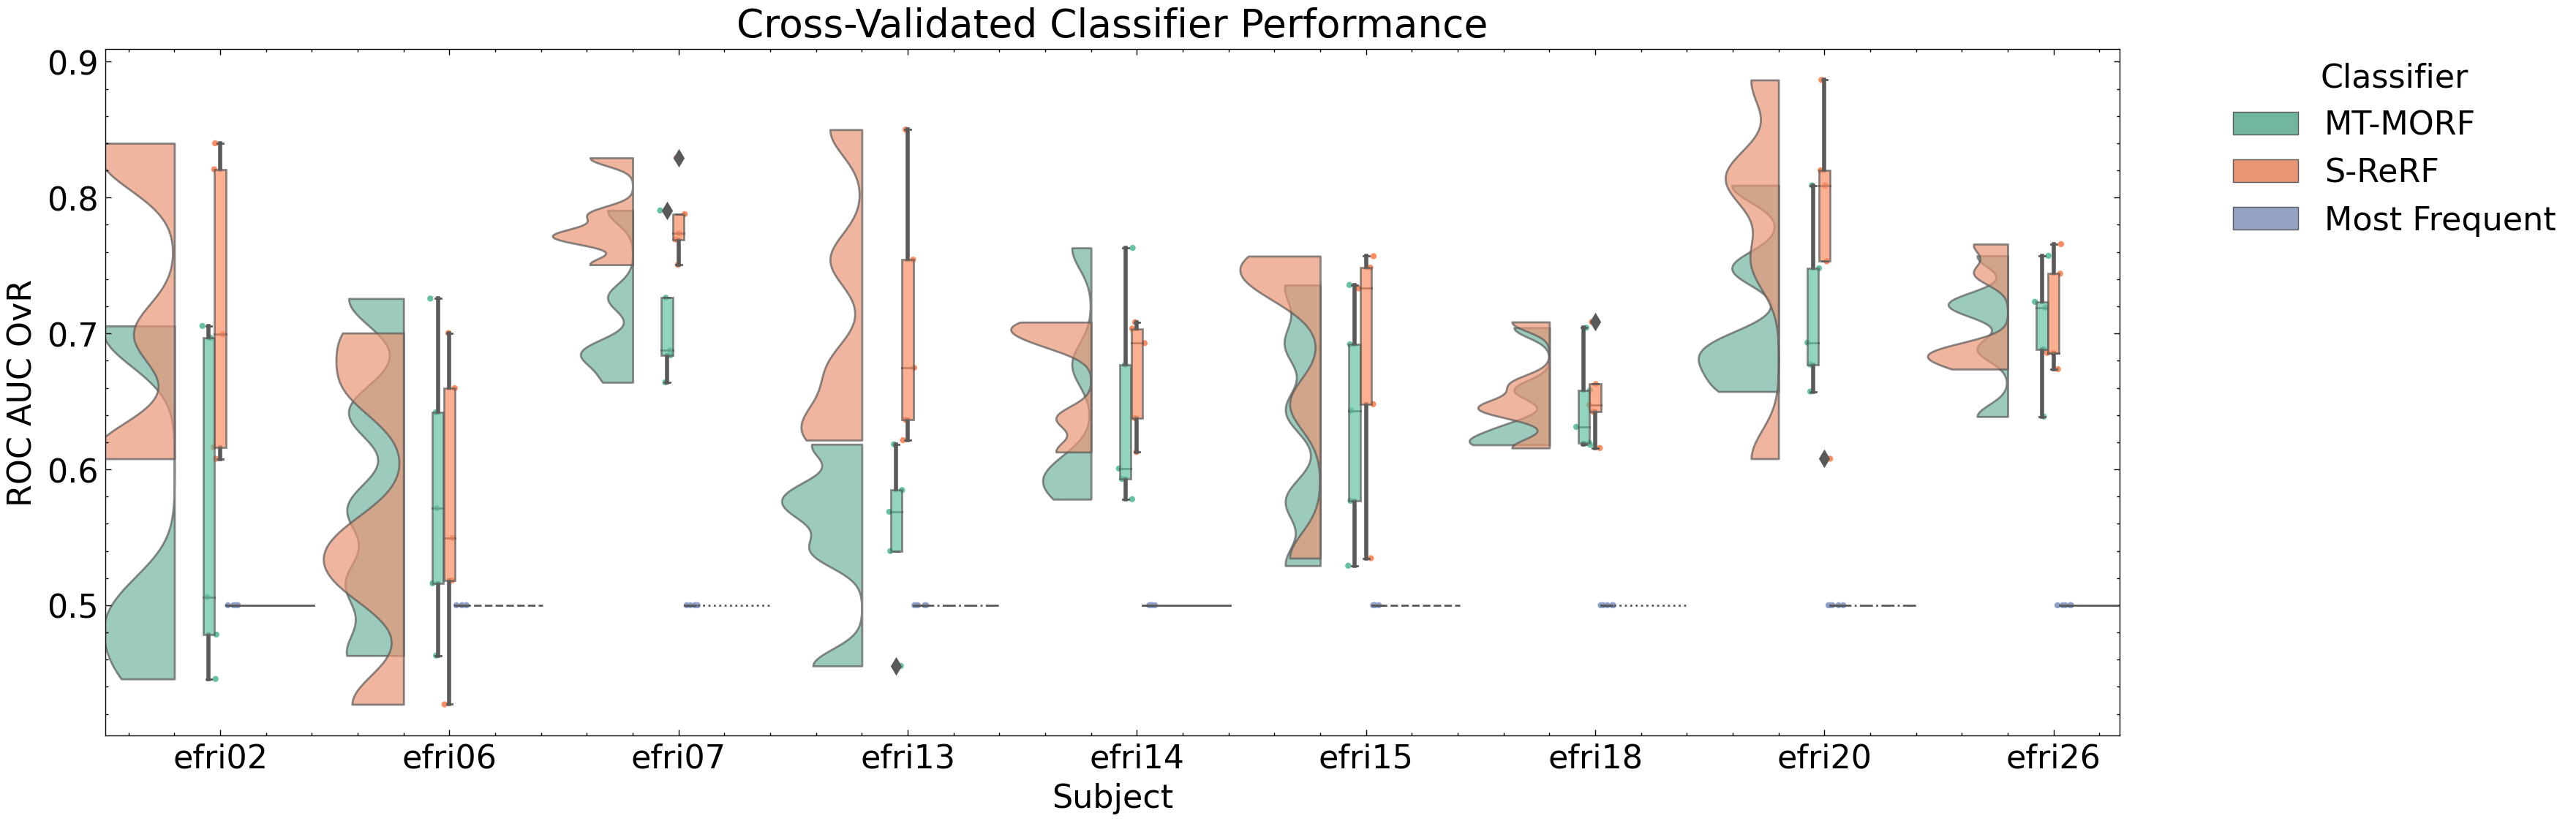

In [28]:
df = pd.DataFrame(columns=["Classifier", "ROC AUC OvR", "Subject"])

for subject, clf_scores in subject_clf_scores.items():
    mtmorf_scores = clf_scores["MT-MORF"]
    srerf_scores = clf_scores["S-RerF"]
    dummy_scores = clf_scores["most_frequent"]

    rocs = {
        "MT-MORF": mtmorf_scores["test_roc_auc_ovr"],
        "S-ReRF": srerf_scores["test_roc_auc_ovr"],
        "Most Frequent": dummy_scores["test_roc_auc_ovr"]
    }
    roc_df = pd.DataFrame(rocs)
    roc_df = pd.melt(roc_df, value_vars=list(rocs.keys()), var_name="Classifier", value_name="ROC AUC OvR")
    roc_df["Subject"] = subject

    df = df.append(roc_df)

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 6), dpi=200)
pt.RainCloud(x="Subject", y="ROC AUC OvR", hue="Classifier", data=df, dodge=True, alpha=0.7, ax=ax)
ax.set_title("Cross-Validated Classifier Performance")
fig.tight_layout();

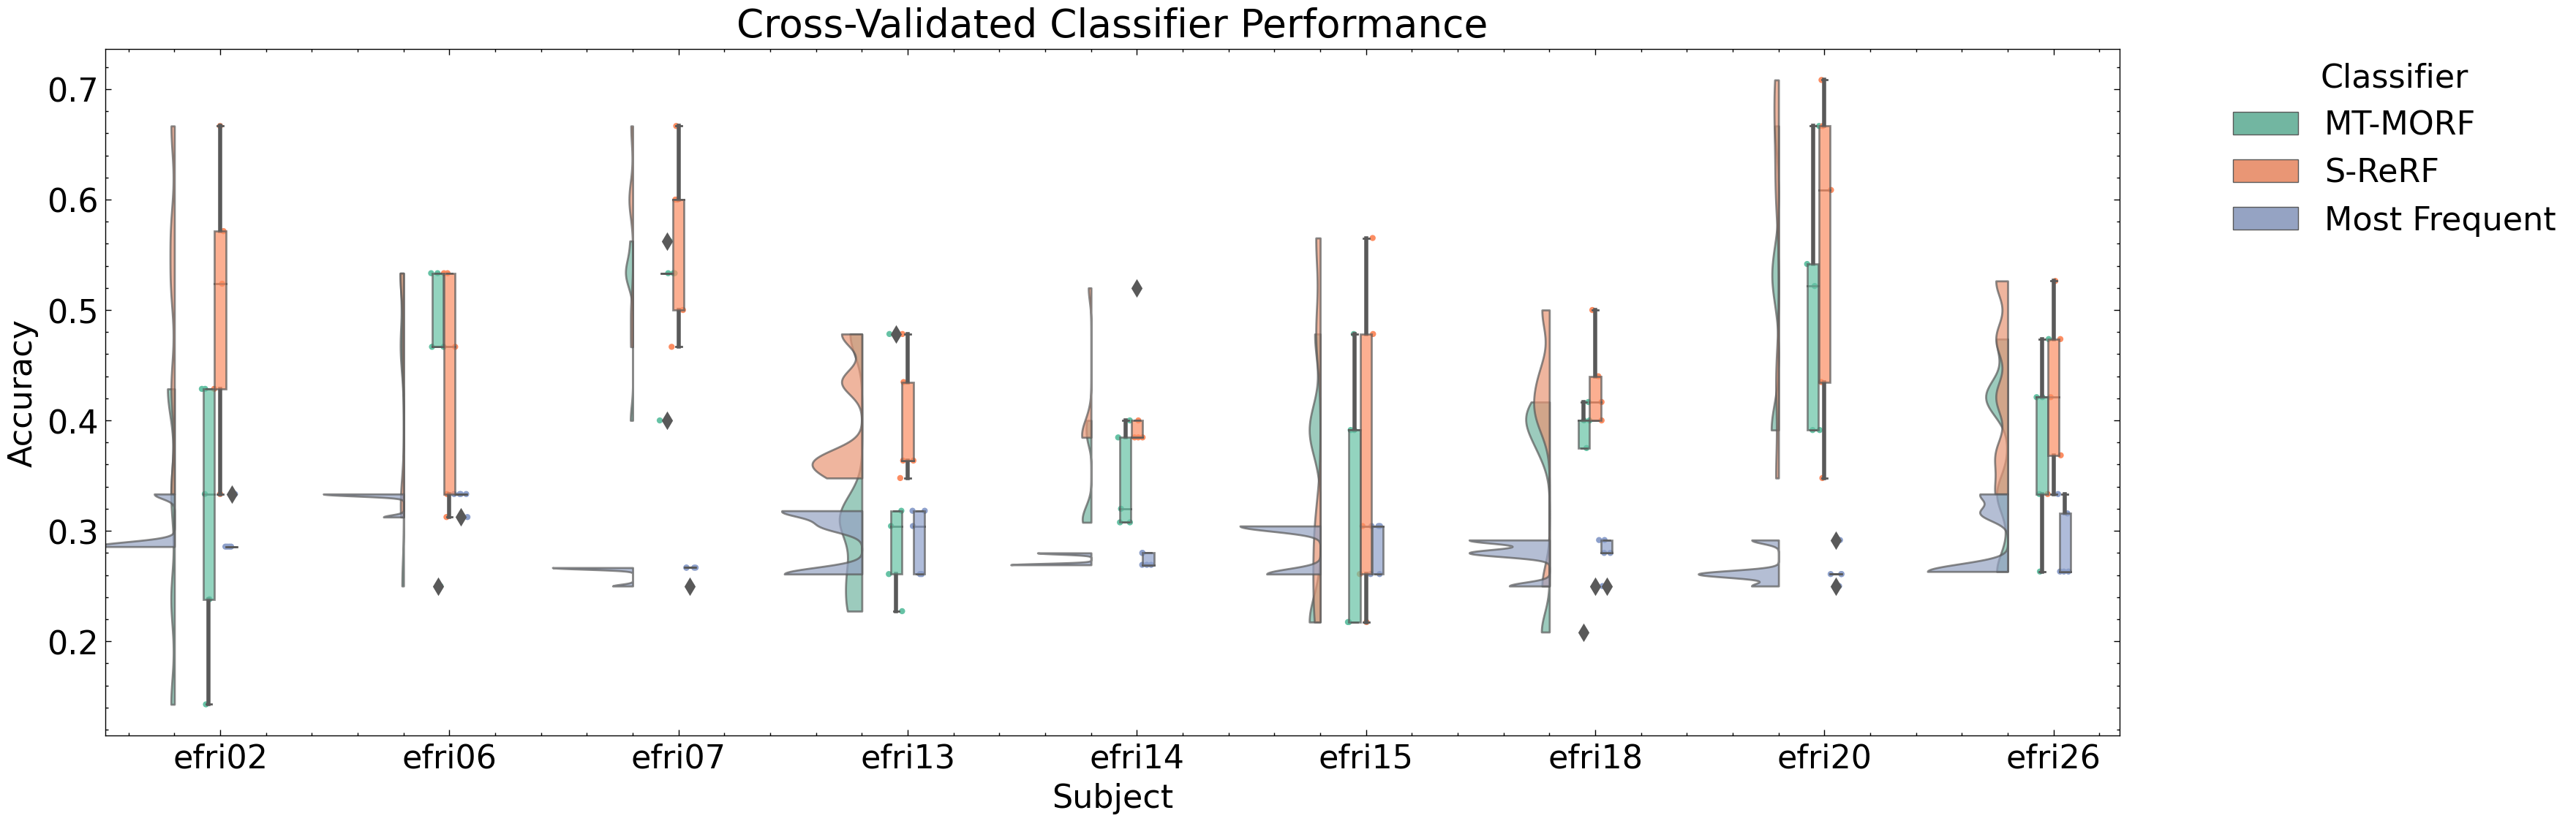

In [29]:
df = pd.DataFrame(columns=["Classifier", "Accuracy", "Subject"])

for subject, clf_scores in subject_clf_scores.items():
    mtmorf_scores = clf_scores["MT-MORF"]
    srerf_scores = clf_scores["S-RerF"]
    dummy_scores = clf_scores["most_frequent"]

    rocs = {
        "MT-MORF": mtmorf_scores["test_accuracy"],
        "S-ReRF": srerf_scores["test_accuracy"],
        "Most Frequent": dummy_scores["test_accuracy"]
    }
    roc_df = pd.DataFrame(rocs)
    roc_df = pd.melt(roc_df, value_vars=list(rocs.keys()), var_name="Classifier", value_name="Accuracy")
    roc_df["Subject"] = subject

    df = df.append(roc_df)

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 6), dpi=200)
pt.RainCloud(x="Subject", y="Accuracy", hue="Classifier", data=df, dodge=True, alpha=0.7, ax=ax)
ax.set_title("Cross-Validated Classifier Performance")
fig.tight_layout();